# Adjust index returns for inflation to get real returns

In [1]:
library(tidyverse)
library(ggthemes)
library(reshape2)
library(odbc)
library(plutoR)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

#initialize
wb <- WorldBank()
indices <- Indices()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘PerformanceAnalytics’

The following obje

### get rate of inflation from the WorldBank data-set

In [2]:
# see example: https://nbviewer.jupyter.org/github/shyams80/plutons/blob/master/docs-R/WorldBank.ipynb

wb$Meta() %>%
    filter(COUNTRY_NAME == "India" & INDICATOR_NAME %like% "CPI%") %>%
    select(INDICATOR_NAME, COUNTRY_KEY, INDICATOR_KEY) %>%
    print(n=Inf)

# Source:   lazy query [?? x 3]
# Database: Microsoft SQL Server 13.00.4224[ro1@NORWAY/StockVizUs]
  INDICATOR_NAME                          COUNTRY_KEY INDICATOR_KEY
  <chr>                                         <int>         <int>
1 CPI Price, nominal                              135             3
2 CPI Price, nominal, seas. adj.                  135             5
3 CPI Price, % y-o-y, nominal, seas. adj.         135             6


In [3]:
# we need the CPI Price, % y-o-y, nominal, seas. adj.
cpiInflation <- wb$TimeSeries() %>%
    filter(COUNTRY_KEY == 135 & INDICATOR_KEY == 6) %>%
    arrange(YEAR) %>%
    select(YEAR, VALUE) %>%
    as.data.frame

print(cpiInflation)

   YEAR     VALUE
1  2018  3.342855
2  2017  3.325906
3  2016  4.948949
4  2015  4.910535
5  2014  6.423176
6  2013 10.100508
7  2012  9.382309
8  2011  8.314037
9  2010 10.360541
10 2009  9.726791
11 2008  8.572874
12 2007  5.991501
13 2006  6.061719
14 2005  3.743798
15 2004  3.853201
16 2003  4.324896
17 2002  5.203442
18 2001  3.684379
19 2000  5.989490
20 1999  5.905776
21 1998  4.473903
22 1997  5.648696
23 1996  8.897228
24 1995 11.339475
25 1994  6.339953
26 1993  6.364231
27 1992 11.793300
28 1991 13.864358
29 1990  8.965143
30 1989  3.274692
31 1988  9.395963
32 1987  8.793766


### get NIFTY 50 total-return index returns from the Indices data-set

In [4]:
indexName <- 'NIFTY 50 TR'
nifty50Dt <- indices$NseTimeSeries() %>%
    filter(NAME == indexName) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect()

annRets <- 100*annualReturn(xts(nifty50Dt$CLOSE, nifty50Dt$TIME_STAMP))

df1 <- data.frame(annRets)
df1$YEAR <- year(index(annRets))

print(df1)

           yearly.returns YEAR
1999-12-30      24.398669 1999
2000-12-29     -13.364088 2000
2001-12-31     -15.048927 2001
2002-12-31       5.336092 2002
2003-12-31      76.611426 2003
2004-12-31      13.035473 2004
2005-12-30      38.633169 2005
2006-12-29      41.900536 2006
2007-12-31      56.804842 2007
2008-12-31     -51.271464 2008
2009-12-31      77.590783 2009
2010-12-31      19.224497 2010
2011-12-30     -23.807885 2011
2012-12-31      29.434881 2012
2013-12-31       8.072455 2013
2014-12-31      32.899200 2014
2015-12-31      -3.013065 2015
2016-12-30       4.394821 2016
2017-12-29      30.266177 2017
2018-12-31       4.638185 2018
2019-07-12       7.075363 2019


In [5]:
# merge the two

allData <- merge(df1, cpiInflation, by='YEAR')
names(allData) <- c('YEAR', 'INDEX', 'INFLATION')
allData$REAL <- allData$INDEX - allData$INFLATION
print(allData)

   YEAR      INDEX INFLATION        REAL
1  1999  24.398669  5.905776  18.4928936
2  2000 -13.364088  5.989490 -19.3535773
3  2001 -15.048927  3.684379 -18.7333060
4  2002   5.336092  5.203442   0.1326498
5  2003  76.611426  4.324896  72.2865296
6  2004  13.035473  3.853201   9.1822718
7  2005  38.633169  3.743798  34.8893713
8  2006  41.900536  6.061719  35.8388166
9  2007  56.804842  5.991501  50.8133405
10 2008 -51.271464  8.572874 -59.8443376
11 2009  77.590783  9.726791  67.8639915
12 2010  19.224497 10.360541   8.8639556
13 2011 -23.807885  8.314037 -32.1219212
14 2012  29.434881  9.382309  20.0525715
15 2013   8.072455 10.100508  -2.0280525
16 2014  32.899200  6.423176  26.4760234
17 2015  -3.013065  4.910535  -7.9235994
18 2016   4.394821  4.948949  -0.5541276
19 2017  30.266177  3.325906  26.9402709
20 2018   4.638185  3.342855   1.2953293


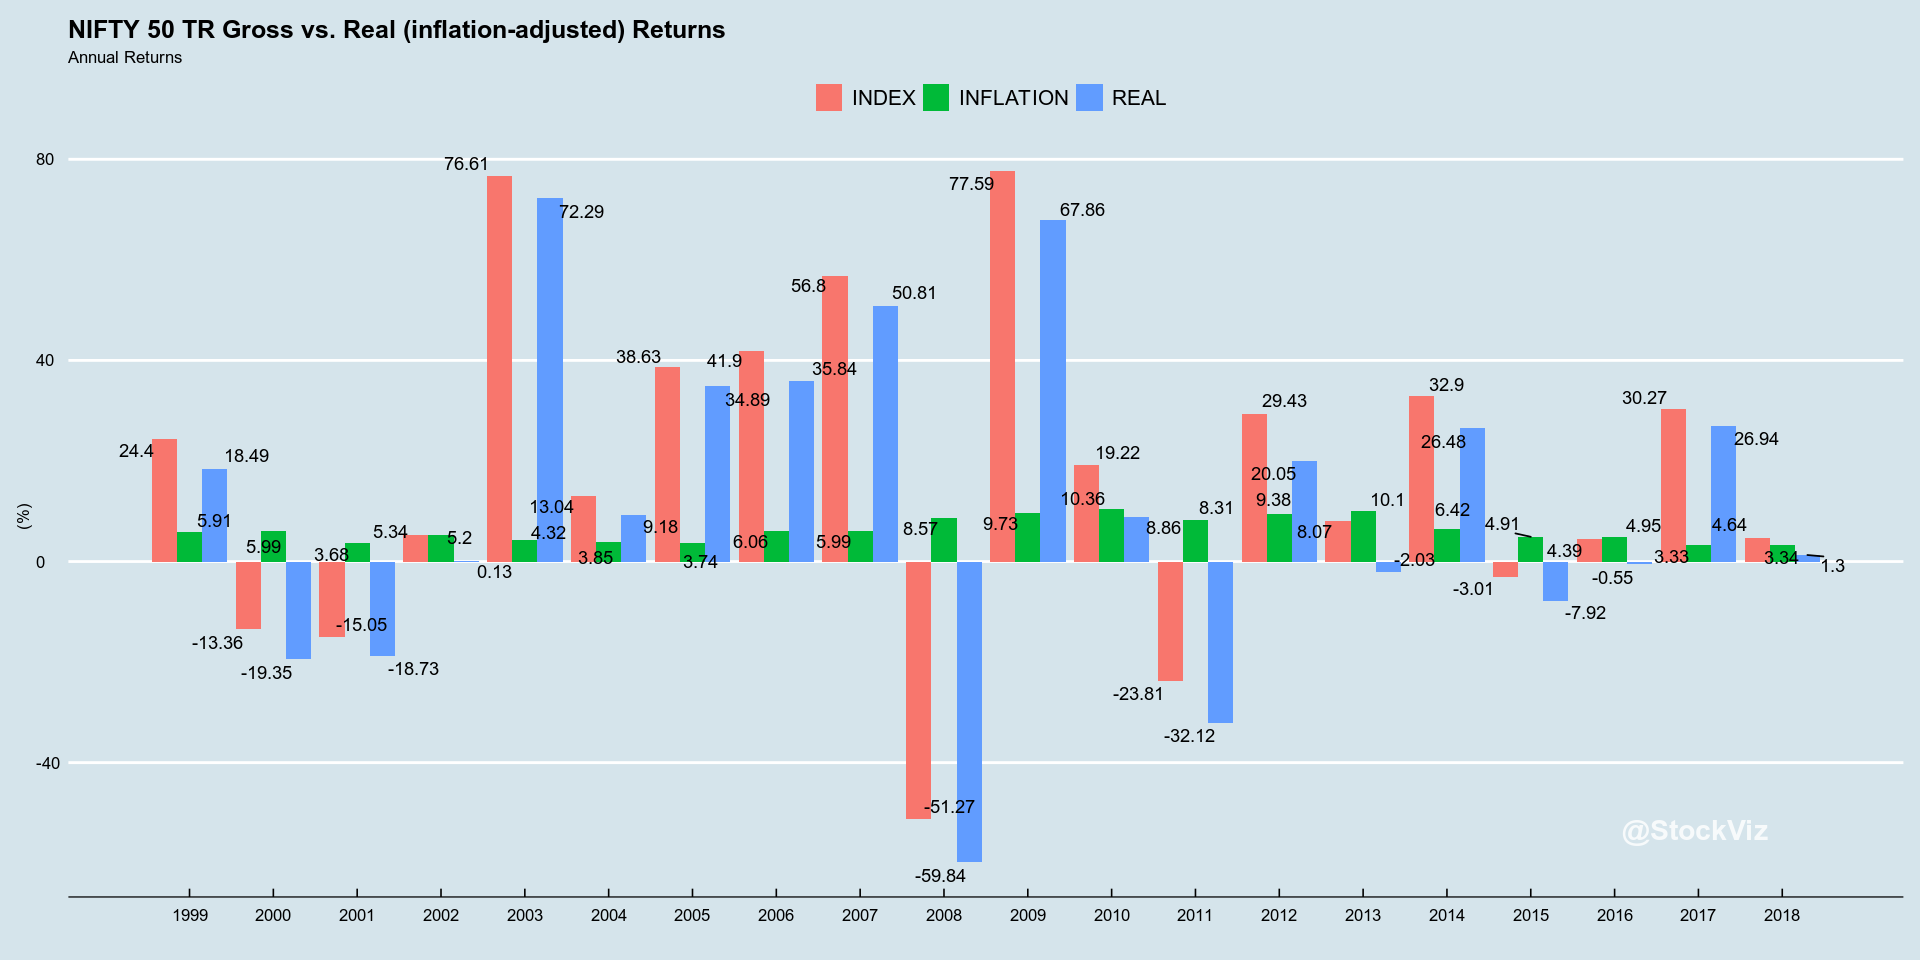

In [6]:
# plot the data

mDf <- melt(allData, id='YEAR')
ggplot(mDf, aes(x=YEAR, y=value, fill=variable)) +
    theme_economist() +
    geom_bar(stat="identity", position=position_dodge()) +
    scale_x_continuous(labels=allData$YEAR, breaks=allData$YEAR) +
    geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title=sprintf("%s Gross vs. Real (inflation-adjusted) Returns", indexName), 
         subtitle="Annual Returns") +
    annotate("text", x=max(allData$YEAR), y=min(mDf$value), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

In [7]:
### calculate rolling 5-year inflation adjusted retuns
rYr <- 5

#cumulative
rollingRets <- 100*rollapply(allData$REAL/100, rYr, Return.cumulative)
print(sprintf("%d-year rolling returns (not annualized):", rYr))
print(rollingRets)
print("Stats:")
print(summary(rollingRets))

[1] "5-year rolling returns (not annualized):"
 [1]  33.972925  23.445954 106.475954 245.128464 419.810238  21.154710
 [7]  86.271203  50.332230 -24.879624 -40.201614  45.896343   9.924643
[13]  -7.026477  36.212356  44.027181  48.912838
[1] "Stats:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -40.20   18.35   40.12   68.72   59.32  419.81 


In [8]:
#annualzied

annRollingRets <- (1+rollingRets/100)^(1/rYr) - 1
annRollingRets <- 100* annRollingRets

print(sprintf("%d-year rolling annualized returns:", rYr))
print(annRollingRets)
print("Stats:")
print(summary(annRollingRets))

[1] "5-year rolling annualized returns:"
 [1]  6.023810  4.302657 15.604276 28.113872 39.049351  3.912564 13.247636
 [8]  8.495174 -5.560963 -9.772714  7.847202  1.910519 -1.446544  6.375913
[15]  7.569436  8.289520
[1] "Stats:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -9.773   3.412   6.973   8.373   9.683  39.049 


This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)